# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN
from keras.utils import to_categorical, plot_model
from keras.datasets import mnist
import cv2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Loading and normalizing dataset

In [ ]:
# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# compute the number of labels
num_labels = len(np.unique(y_train))

# Count the frequency of each digit label in the training set
label_counts = np.bincount(y_train)

# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# resize and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size])
x_test = np.reshape(x_test,[-1, image_size, image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


# Analysis on data

### Here we print a random set of images to see the shape of our data

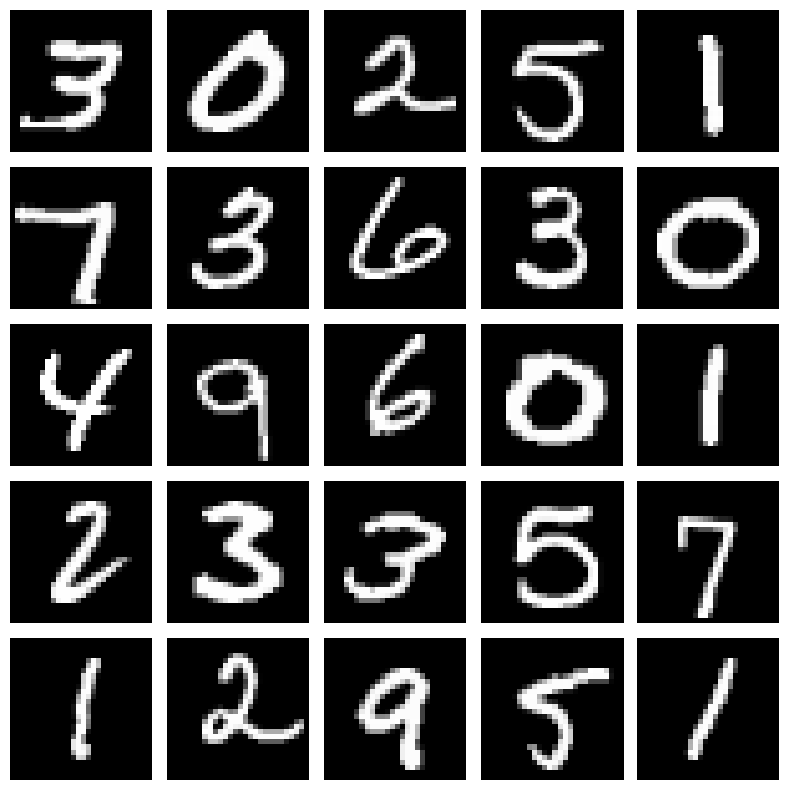

In [ ]:
# Display a random set of images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        rand_idx = np.random.randint(len(x_train))
        ax[i, j].imshow(x_train[rand_idx], cmap='gray')
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

### We want to plot the heatmap of a random set of images to gain insights from the pixel intensities of images and we found that MNIST images contain a centered digit with varying levels of surrounding noise.

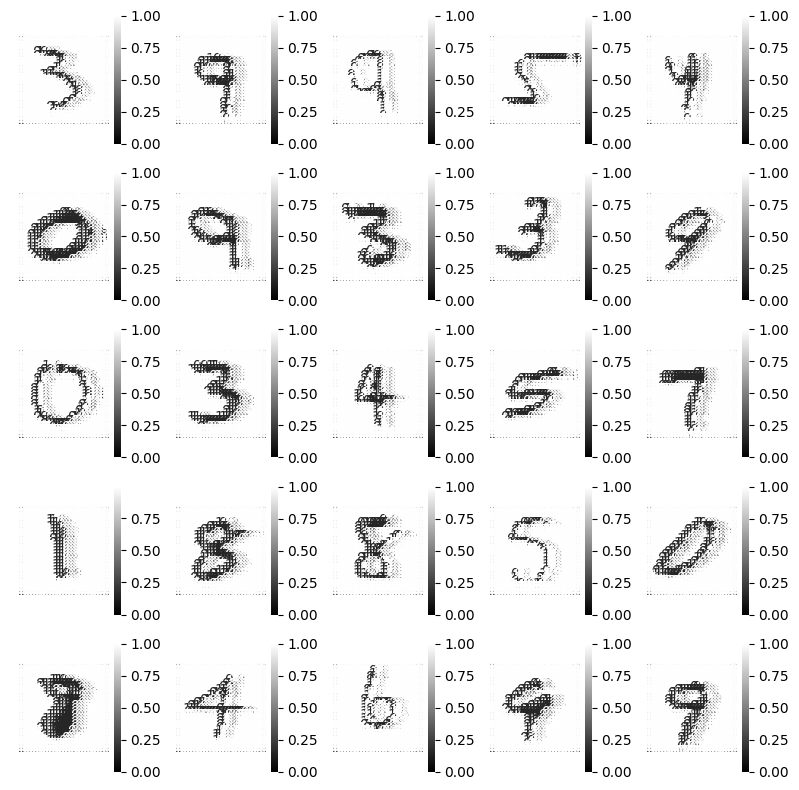

In [ ]:
# Display a random set of images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        rand_idx = np.random.randint(len(x_train))
        ax[i, j].imshow(x_train[rand_idx], cmap='gray')
        ax[i, j].axis('off')
        sns.heatmap(x_train[rand_idx], cmap='gray', annot=True, fmt='.1f', ax=ax[i, j])
plt.tight_layout()
plt.show()

### Here we print the frequency of each digit label

In [ ]:
# Print the frequency of each digit label
for digit, count in enumerate(label_counts):
    print(f"Digit {digit} has a frequency of {count}.")

Digit 0 has a frequency of 5923.
Digit 1 has a frequency of 6742.
Digit 2 has a frequency of 5958.
Digit 3 has a frequency of 6131.
Digit 4 has a frequency of 5842.
Digit 5 has a frequency of 5421.
Digit 6 has a frequency of 5918.
Digit 7 has a frequency of 6265.
Digit 8 has a frequency of 5851.
Digit 9 has a frequency of 5949.


### We created a histogram of the frequency counts and we found that the dataset is relatively balanced

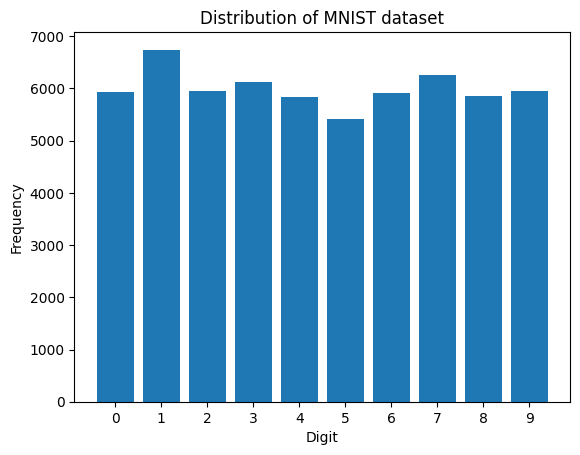

In [ ]:
# Create a histogram of the frequency counts
plt.bar(range(10), label_counts)
plt.xticks(range(10))

plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Distribution of MNIST dataset')
plt.show()

### Here we plotted the pie chart to represent the frequencies of digits in form of precentages in pie charts 

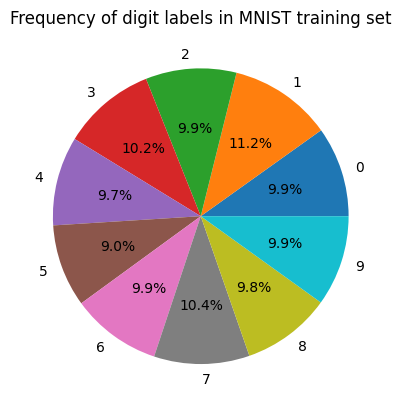

In [ ]:
# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(label_counts, labels=np.arange(10), autopct='%1.1f%%') #%1.1f%%
ax.set_title("Frequency of digit labels in MNIST training set")
plt.show()

### As we say above that MNIST images contain a centered digit with varying levels of surrounding noise so we want to apply some filters on the first image in the training set to overcome the noise but we found that sobel filter affect the edge and make the digit seemed blurry so we didn't apply this filter on our dataset

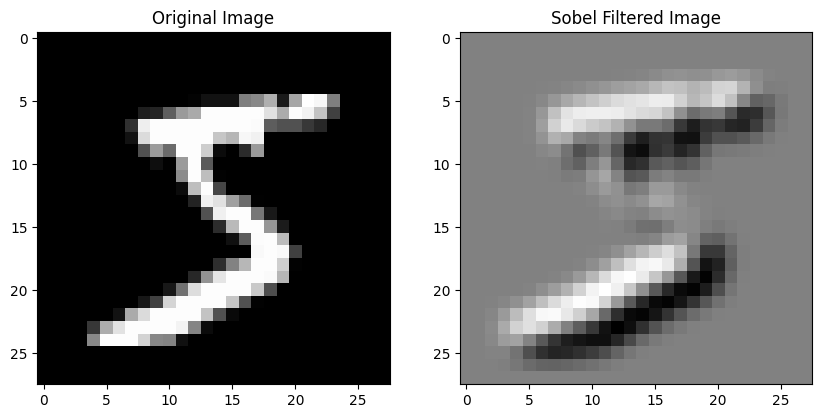

In [ ]:
# Apply Sobel filter to the first image
img = x_train[0]
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
sobel = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)

# Display the original and Sobel filtered images using matplotlib
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(sobel, cmap='gray')
axs[1].set_title('Sobel Filtered Image')
plt.show()

### Also the Gaussian filter made the image seemed blurry the same as sobel filter

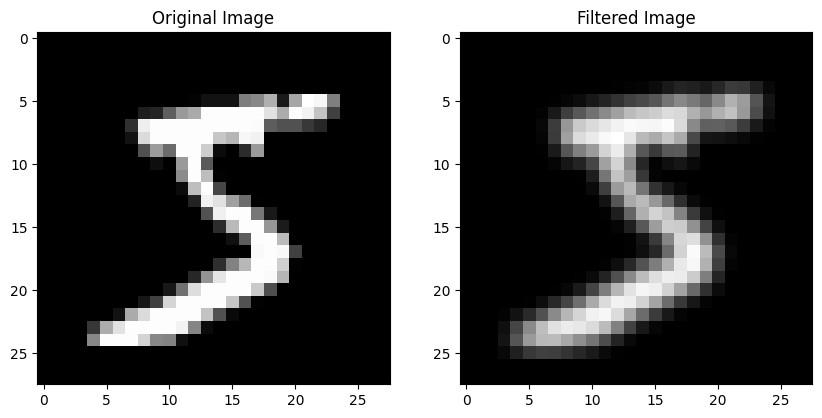

In [ ]:
# Apply Gaussian filter to the first image
img = x_train[0]
filtered_img = cv2.GaussianBlur(img, (3, 3), 0)

# Display the original and filtered images using Matplotlib
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(filtered_img, cmap='gray')
axs[1].set_title('Filtered Image')
plt.show()

### We didn't apply segmentation since that segmentation is not needed for the MNIST dataset as each image in the dataset contains only a single digit and the digits are already centered in the images

# Modeling

### The model architecture consists of a SimpleRNN layer with 256 units, followed by a Dense layer with the number of output labels and a softmax activation function. The input shape is a 28x28-dimensional vector, with 28 timesteps. The batch size is set to 128 and a dropout rate of 0.2 is used.
#### *None in the output shape represents the batch size which we we will put it in the cell of fitting our network.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               72960     
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 75,530
Trainable params: 75,530
Non-trainable params: 0
_________________________________________________________________


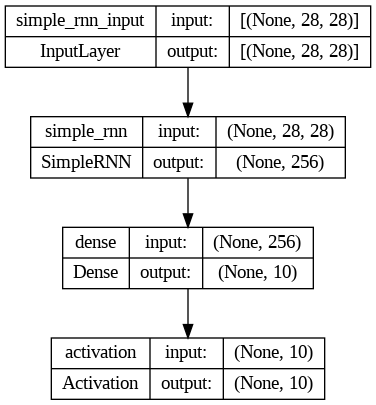

In [ ]:
# network parameters
input_shape = (image_size, image_size)
batch_size = 128
units = 256
dropout = 0.2

# model is RNN with 256 units, input is 28-dim vector 28 timesteps
model = Sequential()
model.add(SimpleRNN(units=units,
                    input_shape=input_shape)) #batch_size = batch_size
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
plot_model(model, to_file='rnn-mnist.png', show_shapes=True)

### We used categorical_crossentropy loss function since we have a multiclass classification problem

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# train the network
r = model.fit(x_train, y_train, epochs=5, batch_size=batch_size,validation_data=(x_test, y_test))

Epoch 1/5
469/469 [==============================] - 23s 26ms/step - loss: 0.3279 - accuracy: 0.9008 - val_loss: 0.1891 - val_accuracy: 0.9478
Epoch 2/5
469/469 [==============================] - 10s 22ms/step - loss: 0.1617 - accuracy: 0.9511 - val_loss: 0.1250 - val_accuracy: 0.9633
Epoch 3/5
469/469 [==============================] - 11s 23ms/step - loss: 0.1343 - accuracy: 0.9609 - val_loss: 0.1061 - val_accuracy: 0.9690
Epoch 4/5
469/469 [==============================] - 11s 24ms/step - loss: 0.1124 - accuracy: 0.9669 - val_loss: 0.1163 - val_accuracy: 0.9652
Epoch 5/5
469/469 [==============================] - 11s 24ms/step - loss: 0.1033 - accuracy: 0.9700 - val_loss: 0.1030 - val_accuracy: 0.9711


In [ ]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

79/79 [==============================] - 0s 5ms/step - loss: 0.1030 - accuracy: 0.9711

Test accuracy: 97.1%


# Loss and accuracy charts

### We found that the loss and validation loss decrease continuously till they converge

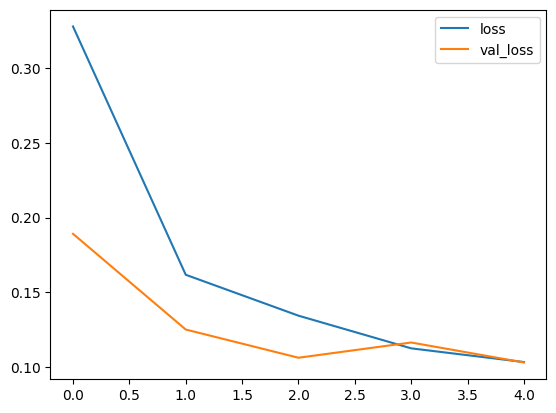

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label= 'loss')
plt.plot(r.history['val_loss'], label= 'val_loss')
plt.legend()

### Here the accuracy and validation accuracy increase till it reaches a good values

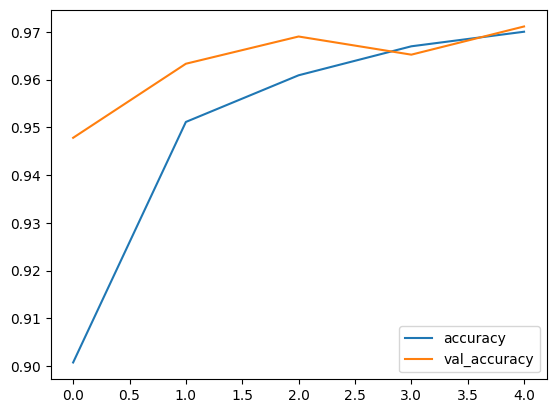

In [ ]:
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.plot(r.history['val_accuracy'], label= 'val_accuracy')
plt.legend()

# Confusion matrix

313/313 [==============================] - 1s 4ms/step
Confusion matrix without normalization
[[ 968    0    0    1    0    1    4    2    3    1]
 [   0 1124    5    0    0    1    2    0    3    0]
 [   0    3 1000   15    3    0    1    5    5    0]
 [   0    2    5  983    0    7    0    7    0    6]
 [   0    0    2    1  963    0    2    1    2   11]
 [   4    2    0    6    3  857    5    1    2   12]
 [   4    4    0    1    8   10  926    0    5    0]
 [   0    1   18    1    2    0    0  996    1    9]
 [   2    3    2   16    7   12    2    4  916   10]
 [   0    2    0    5   12    6    0    5    1  978]]


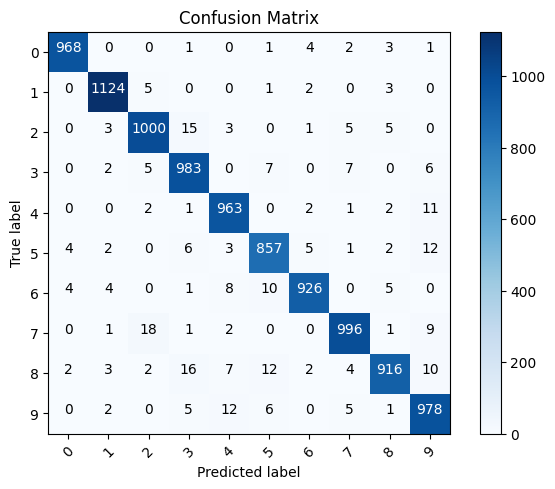

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title="Confusion Matrix",
                          cmap = plt.cm.Blues):
  
  """
  This function prints and plots the confusion matrix.
  Normalize can be applied by setting 'normalize = True'
  """
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    print("Normalized Confusion Matrix")
  
  else:
    print("Confusion matrix without normalization")
  
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = 'center',
             color = "white" if cm[i, j] > thresh else "black")
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test.argmax(axis=1), p_test)
plot_confusion_matrix(cm, list(range(10)))   

# Printing misclassified digit 

### Here we print a missclassified digit to see where our model cann't predict right

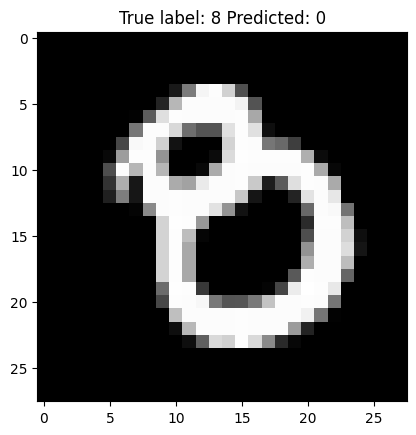

In [ ]:
misclassified_idx = np.where(p_test != y_test.argmax(axis=1))[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap= 'gray')
plt.title("True label: %s Predicted: %s" % (y_test.argmax(axis=1)[i], p_test[i]));

# Grid search

### We concatenated our data because we are using cross-validation so we give the whole data as input and it will be divided to the number of folds we choose

In [ ]:
print("X train shape : ", x_train.shape)
# Concatenate x_train and x_test
x = np.concatenate((x_train, x_test), axis=0)
print("X shape : ", x.shape)

print("Y train shape : ", y_train.shape)
# Concatenate y_train and y_test
y = np.concatenate((y_train, y_test), axis=0)
print("Y shape : ", y.shape)

X train shape :  (60000, 28, 28)
X shape :  (70000, 28, 28)
Y train shape :  (60000, 10)
Y shape :  (70000, 10)


### Here we use grid search (Grid search is a hyperparameter tuning technique used to systematically search for the optimal combination of hyperparameters for a given model) so we used different units of RNN, batch size, epochs and optimzers to see which combination will output the best result 

In [ ]:
def create_model(units, optimizer):
    input_shape = (image_size, image_size)
    model = Sequential()
    model.add(SimpleRNN(units=units, input_shape=input_shape))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    return model

# Define the hyperparameters to tune
param_grid = {'units': [128, 256], ## 16, 32, 64, 128, 256
              'batch_size': [128, 256],
              'epochs': [5, 10],
              'optimizer': ['adam', 'sgd']}

# Create a KerasClassifier
model = KerasClassifier(build_fn=create_model)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(x, y, verbose = 0)

# Print overall results
print("Results:")
for mean_score, std_score, params in zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params']):
    print("Mean validation score: {:.4f} (±{:.4f})".format(mean_score, std_score), "Parameters:", params)

# Print the best parameters and best score
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

92/92 [==============================] - 1s 7ms/step - loss: 0.1612 - accuracy: 0.9526
Results:
Mean validation score: 0.9583 (±0.0075) Parameters: {'batch_size': 128, 'epochs': 5, 'optimizer': 'adam', 'units': 128}
Mean validation score: 0.9634 (±0.0058) Parameters: {'batch_size': 128, 'epochs': 5, 'optimizer': 'adam', 'units': 256}
Mean validation score: 0.9324 (±0.0067) Parameters: {'batch_size': 128, 'epochs': 5, 'optimizer': 'sgd', 'units': 128}
Mean validation score: 0.9438 (±0.0101) Parameters: {'batch_size': 128, 'epochs': 5, 'optimizer': 'sgd', 'units': 256}
Mean validation score: 0.9656 (±0.0025) Parameters: {'batch_size': 128, 'epochs': 10, 'optimizer': 'adam', 'units': 128}
Mean validation score: 0.9648 (±0.0050) Parameters: {'batch_size': 128, 'epochs': 10, 'optimizer': 'adam', 'units': 256}
Mean validation score: 0.9571 (±0.0021) Parameters: {'batch_size': 128, 'epochs': 10, 'optimizer': 'sgd', 'units': 128}
Mean validation score: 0.9662 (±0.0017) Parameters: {'batch_size

### Here we plot bar chart with the different combination of hyperparamters and as we see we found that 'batch_size': 256, 'epochs': 10, 'optimizer': 'adam', 'units': 256 is the best combination

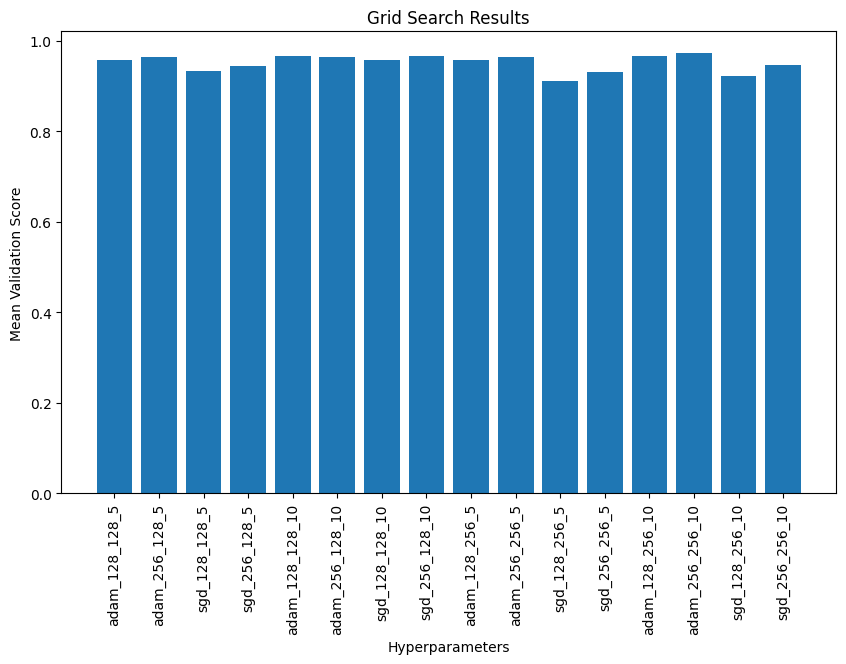

In [ ]:
# Extract the hyperparameters and scores
params = [str(x['optimizer']) + '_' + str(x['units']) + '_' + str(x['batch_size']) + '_' + str(x['epochs']) for x in grid_result.cv_results_['params']]
scores = grid_result.cv_results_['mean_test_score']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(params, scores)
plt.title('Grid Search Results')
plt.xlabel('Hyperparameters')
plt.ylabel('Mean Validation Score')
plt.xticks(rotation=90)
plt.show()